# Calcium overload

Steady-state solutions across a range of glucose levels.

In [1]:
using DifferentialEquations
using ModelingToolkit
using MitochondrialDynamics
using MitochondrialDynamics: μM
import PythonPlot as plt
plt.matplotlib.rcParams["font.size"] = 14

14

Default model

In [2]:
@named sys = make_model()
prob = SteadyStateProblem(sys, [])
alg = DynamicSS(Rodas5())
sol = solve(prob, alg)

retcode: Success
u: 9-element Vector{Float64}:
 0.05726539036425409
 0.0009825436375669918
 0.00020114170980325592
 0.09199008563917668
 0.002828010003233753
 0.008756932513658812
 0.8765023198088259
 0.2432682292643292
 0.058666961905366

High calcium model

In [3]:
@unpack RestingCa, ActivatedCa = sys
prob_ca5 = SteadyStateProblem(sys, [], [RestingCa=>0.45μM, ActivatedCa=>1.25μM])
prob_ca10 = SteadyStateProblem(sys, [], [RestingCa=>0.9μM, ActivatedCa=>2.5μM])

SteadyStateProblem with uType Vector{Float64}. In-place: true
u0: 9-element Vector{Float64}:
 0.057
 0.001
 0.0002
 0.092
 0.0029
 0.0087
 0.9
 0.24
 0.06

Simulating on a range of glucose

In [4]:
@unpack GlcConst = sys

Model sys with 9 equations
Unknowns (9):
  NADH_m(t) [defaults to 0.057]
  NADH_c(t) [defaults to 0.001]
  Ca_m(t) [defaults to 0.0002]
  ΔΨm(t) [defaults to 0.092]
⋮
Parameters (64):
  NCac [defaults to 4]
  ActivatedCa [defaults to 0.00025]
  KatpCac [defaults to 25]
  RestingCa [defaults to 9.0e-5]
⋮

Test on a range of glucose

In [5]:
glc = 3.5:0.5:30.0
prob_func = (prob, i, repeat) -> begin
    remake(prob, p=[GlcConst => glc[i]])
end

trajectories=length(glc)

sim = solve(EnsembleProblem(prob; prob_func, safetycopy=false), alg; trajectories)
sim_ca5 = solve(EnsembleProblem(prob_ca5; prob_func, safetycopy=false), alg; trajectories)
sim_ca10 = solve(EnsembleProblem(prob_ca10; prob_func, safetycopy=false), alg; trajectories);

## Steady states for a range of glucose

In [6]:
function plot_steady_state(glc, sols, sys; figsize=(10, 10), title="")

    @unpack G3P, Pyr, Ca_c, Ca_m, NADH_c, NADH_m, NAD_c, NAD_m, ATP_c, ADP_c, AMP_c, ΔΨm, x1, x2, x3, degavg = sys

    glc5 = glc ./ 5
    g3p = extract(sols, G3P * 1000)
    pyr = extract(sols, Pyr * 1000)
    ca_c = extract(sols, Ca_c * 1000)
    ca_m = extract(sols, Ca_m * 1000)
    nad_ratio_c = extract(sols, NADH_c/NAD_c)
    nad_ratio_m = extract(sols, NADH_m/NAD_m)
    atp_c = extract(sols, ATP_c * 1000)
    adp_c = extract(sols, ADP_c * 1000)
    amp_c = extract(sols, AMP_c * 1000)
    td = extract(sols, ATP_c / ADP_c)
    dpsi = extract(sols, ΔΨm * 1000)
    x1 = extract(sols, x1)
    x2 = extract(sols, x2)
    x3 = extract(sols, x3)
    deg = extract(sols, degavg)

    numrows = 3
    numcols = 3

    fig, ax = plt.subplots(numrows, numcols; figsize)

    ax[0, 0].plot(glc5, g3p)
    ax[0, 0].set(ylabel="G3P (μM)")
    ax[0, 0].set_title("a", loc="left")
    ax[0, 1].plot(glc5, pyr)
    ax[0, 1].set(ylabel="Pyruvate (μM)")
    ax[0, 1].set_title("b", loc="left")
    ax[0, 2].plot(glc5, ca_c, label="cyto")
    ax[0, 2].plot(glc5, ca_m, label="mito")
    ax[0, 2].legend()
    ax[0, 2].set(ylabel="Calcium (μM)")
    ax[0, 2].set_title("c", loc="left")
    ax[1, 0].plot(glc5, nad_ratio_c, label="cyto")
    ax[1, 0].plot(glc5, nad_ratio_m, label="mito")
    ax[1, 0].legend()
    ax[1, 0].set(ylabel="NADH:NAD (ratio)")
    ax[1, 0].set_title("d", loc="left")
    ax[1, 1].plot(glc5, atp_c, label="ATP")
    ax[1, 1].plot(glc5, adp_c, label="ADP")
    ax[1, 1].plot(glc5, amp_c, label="AMP")
    ax[1, 1].legend()
    ax[1, 1].set(ylabel="Adenylates (μM)")
    ax[1, 1].set_title("e", loc="left")
    ax[1, 2].plot(glc5, td)
    ax[1, 2].set(ylabel="ATP:ADP (ratio)")
    ax[1, 2].set_title("f", loc="left")
    ax[2, 0].plot(glc5, dpsi, label="cyto")
    ax[2, 0].set(ylabel="ΔΨ (mV)", xlabel="Glucose (X)")
    ax[2, 0].set_title("g", loc="left")
    ax[2, 1].plot(glc5, x1, label="X1")
    ax[2, 1].plot(glc5, x2, label="X2")
    ax[2, 1].plot(glc5, x3, label="X3")
    ax[2, 1].set(ylabel="Mitochondrial nodes (a.u.)", xlabel="Glucose (X)")
    ax[2, 1].set_title("h", loc="left")
    ax[2, 2].plot(glc5, deg)
    ax[2, 2].set(ylabel="Avg. Node Degree (a.u.)", xlabel="Glucose (X)")
    ax[2, 2].set_title("i", loc="left")

    for i in 0:numrows-1, j in 0:numcols-1
        ax[i, j].set_xticks(1:6)
        ax[i, j].grid()
    end
    fig.suptitle(title)
    fig.tight_layout()
    return fig
end

plot_steady_state (generic function with 1 method)

Default model

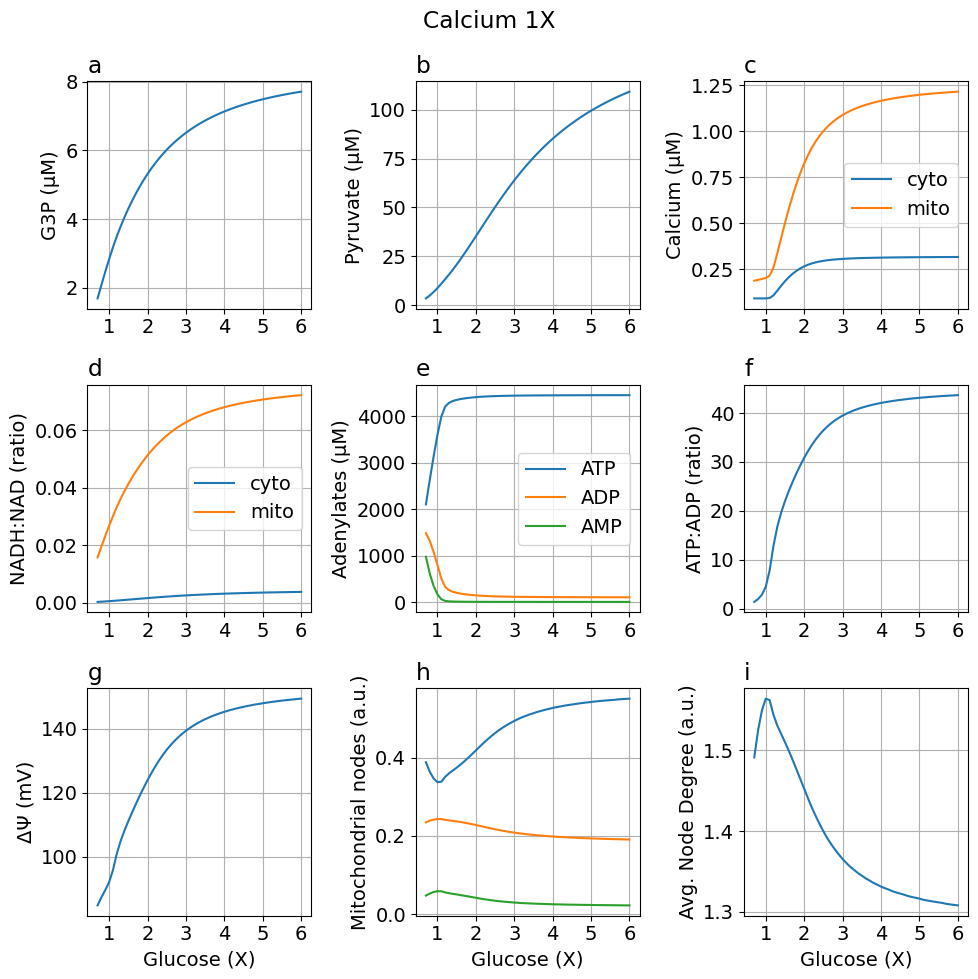

In [7]:
fig_glc_default = plot_steady_state(glc, sim, sys, title="Calcium 1X")

High calcium (5X)

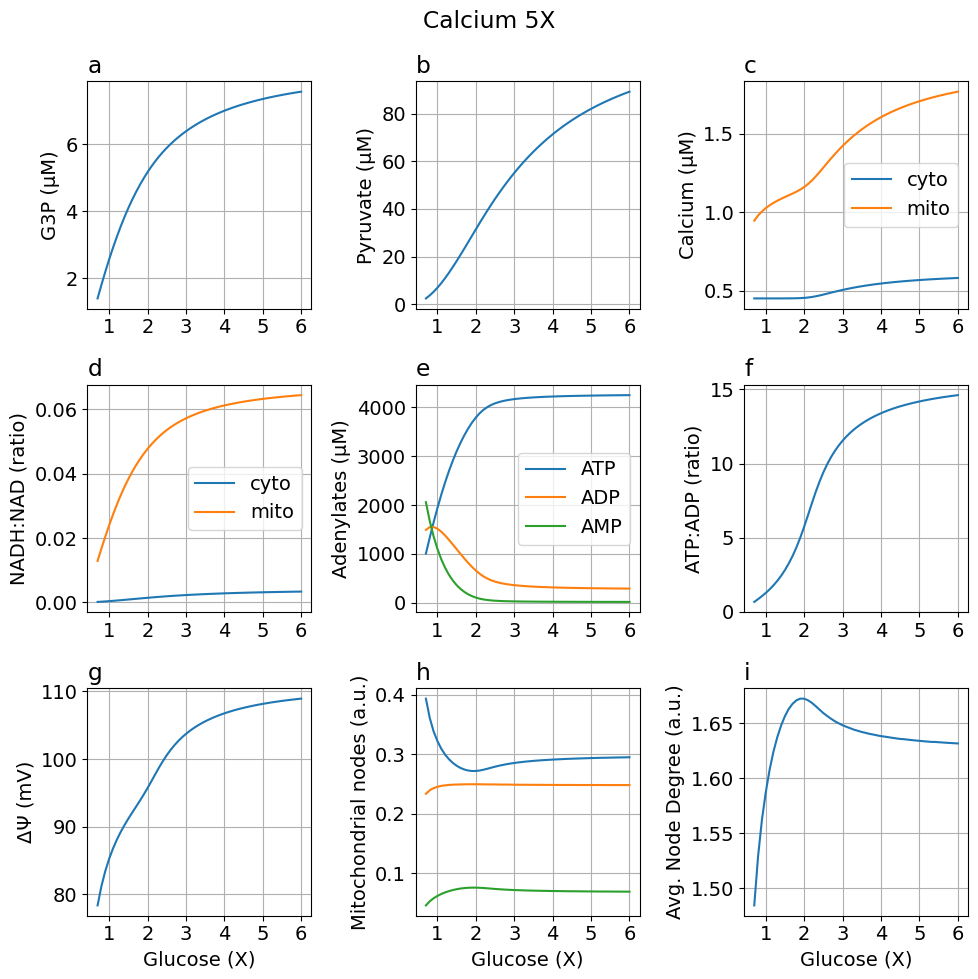

In [8]:
fig_ca5 = plot_steady_state(glc, sim_ca5, sys, title="Calcium 5X")

High calcium (10X)

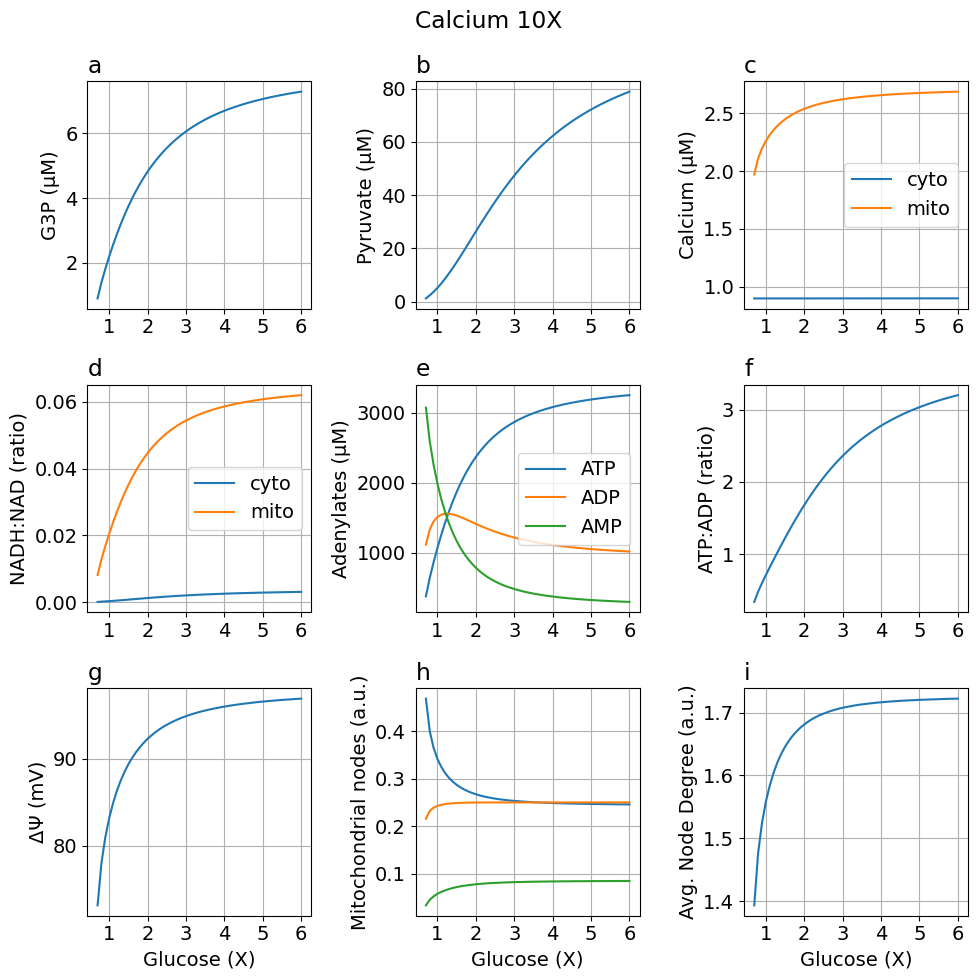

In [9]:
fig_ca10 = plot_steady_state(glc, sim_ca10, sys, title="Calcium 10X")

## Comparing default and high calcium models

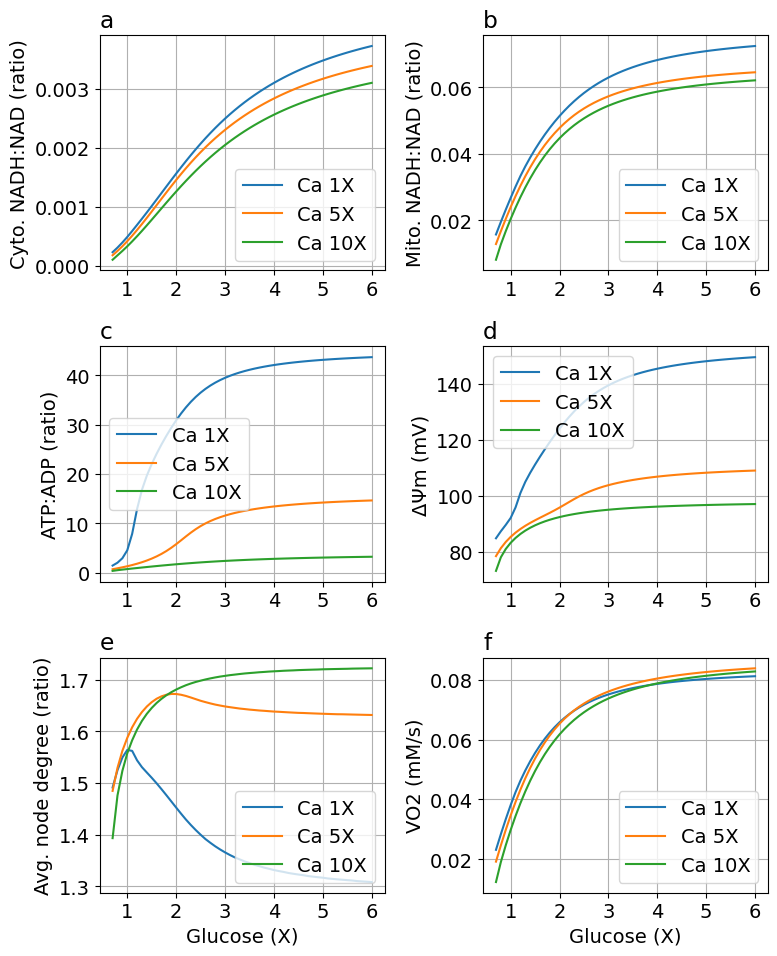

In [10]:
function plot_comparision(glc, sim, sim_ca5, sim_ca10, sys;
    figsize=(8, 10), title="", labels=["Ca 1X", "Ca 5X", "Ca 10X"]
)
    @unpack G3P, Pyr, Ca_c, Ca_m, NADH_c, NADH_m, NAD_c, NAD_m, ATP_c, ADP_c, AMP_c, ΔΨm, degavg, J_O2 = sys

    glc5 = glc ./ 5

    numrows = 3
    numcols = 2
    fig, ax = plt.subplots(numrows, numcols; figsize)

    ax[0, 0].set_title("a", loc="left")
    ax[0, 0].set_ylabel("Cyto. NADH:NAD (ratio)")
    k = NADH_c/NAD_c
    yy = [extract(sim, k) extract(sim_ca5, k) extract(sim_ca10, k)]
    lines = ax[0, 0].plot(glc5, yy)
    ax[0, 0].legend(lines, labels)

    ax[0, 1].set_title("b", loc="left")
    ax[0, 1].set_ylabel("Mito. NADH:NAD (ratio)")
    k = NADH_m/NAD_m
    yy = [extract(sim, k) extract(sim_ca5, k) extract(sim_ca10, k)]
    lines = ax[0, 1].plot(glc5, yy)
    ax[0, 1].legend(lines, labels)

    ax[1, 0].set_title("c", loc="left")
    ax[1, 0].set_ylabel("ATP:ADP (ratio)")
    k = ATP_c/ADP_c
    yy = [extract(sim, k) extract(sim_ca5, k) extract(sim_ca10, k)]
    lines = ax[1, 0].plot(glc5, yy)
    ax[1, 0].legend(lines, labels)

    ax[1, 1].set_title("d", loc="left")
    ax[1, 1].set_ylabel("ΔΨm (mV)")
    k = ΔΨm * 1000
    yy = [extract(sim, k) extract(sim_ca5, k) extract(sim_ca10, k)]
    lines = ax[1, 1].plot(glc5, yy)
    ax[1, 1].legend(lines, labels)

    ax[2, 0].set_title("e", loc="left")
    ax[2, 0].set_ylabel("Avg. node degree (ratio)")
    k = degavg
    yy = [extract(sim, k) extract(sim_ca5, k) extract(sim_ca10, k)]
    lines = ax[2, 0].plot(glc5, yy)
    ax[2, 0].legend(lines, labels, loc="lower right")
    ax[2, 0].set(xlabel="Glucose (X)")

    ax[2, 1].set_title("f", loc="left")
    ax[2, 1].set_ylabel("VO2 (mM/s)")
    k = J_O2
    yy = [extract(sim, k) extract(sim_ca5, k) extract(sim_ca10, k)]
    lines = ax[2, 1].plot(glc5, yy)
    ax[2, 1].legend(lines, labels)
    ax[2, 1].set(xlabel="Glucose (X)")

    for i in 0:numrows-1, j in 0:numcols-1
        ax[i, j].set_xticks(1:6)
        ax[i, j].grid()
    end

    fig.suptitle(title)
    fig.tight_layout()
    return fig
end

figcomp = plot_comparision(glc, sim, sim_ca5, sim_ca10, sys)

Export figure

In [11]:
exportTIF(figcomp, "S1_HighCa.tif")

Python: None

## MMP vs <k>

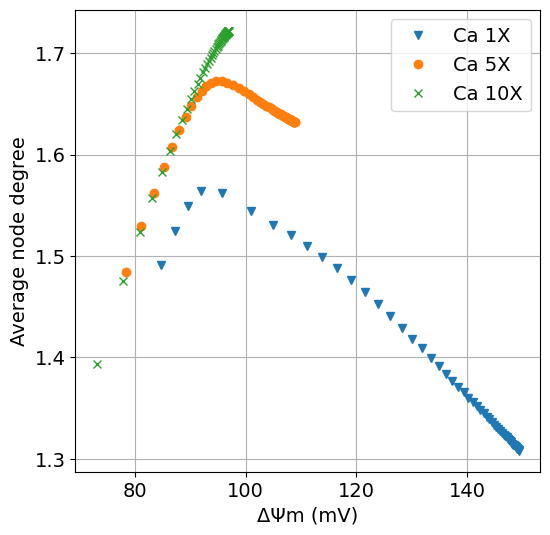

In [12]:
function plot_dpsi_k(sim, sim_ca5, sim_ca10, sys; figsize=(6,6), title="", labels=["Ca 1X", "Ca 5X", "Ca 10X"])
    @unpack ΔΨm, degavg = sys

    fig, ax = plt.subplots(1, 1; figsize)

    ax.plot(extract(sim, ΔΨm * 1000), extract(sim, degavg), "v", label=labels[1])
    ax.plot(extract(sim_ca5, ΔΨm * 1000), extract(sim_ca5, degavg), "o", label=labels[2])
    ax.plot(extract(sim_ca10, ΔΨm * 1000), extract(sim_ca10, degavg), "x", label=labels[3])
    ax.set(xlabel="ΔΨm (mV)", ylabel="Average node degree", title=title)
    ax.legend()
    ax.grid()

    return fig
end

fig = plot_dpsi_k(sim, sim_ca5, sim_ca10, sys)

In [13]:
# exportTIF(fig, "S1_HighCa_dpsi_k.tif")

## x-axis as Ca2+ and y-axis as average node degree

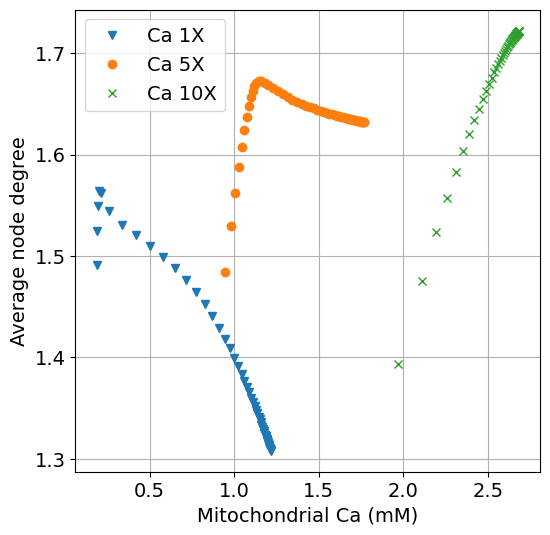

In [14]:
function plot_ca_k(sim, sim_ca5, sim_ca10, sys; figsize=(6,6), title="", labels=["Ca 1X", "Ca 5X", "Ca 10X"])
    @unpack Ca_m, degavg = sys

    fig, ax = plt.subplots(1, 1; figsize)

    ax.plot(extract(sim, Ca_m * 1000), extract(sim, degavg), "v", label=labels[1])
    ax.plot(extract(sim_ca5, Ca_m * 1000), extract(sim_ca5, degavg), "o", label=labels[2])
    ax.plot(extract(sim_ca10, Ca_m * 1000), extract(sim_ca10, degavg), "x", label=labels[3])
    ax.set(xlabel="Mitochondrial Ca (mM)", ylabel="Average node degree", title=title)
    ax.legend()
    ax.grid()
    return fig
end

fig = plot_ca_k(sim, sim_ca5, sim_ca10, sys)

In [15]:
exportTIF(fig, "S1_HighCa_ca_k.tif")

Python: None

## x-axis as ATP and y-axis as average node degree

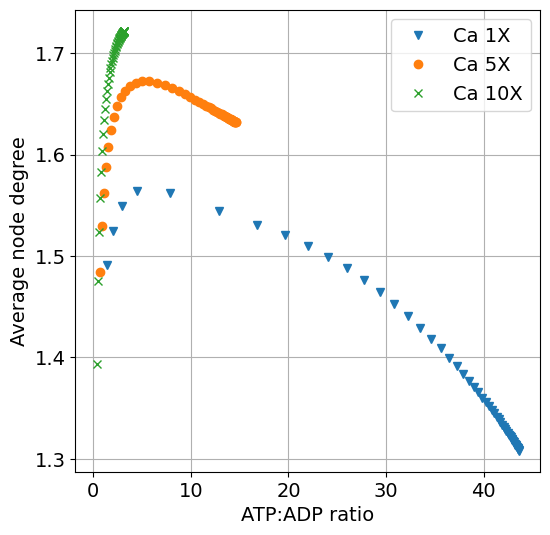

In [16]:
function plot_atp_k(sim, sim_ca5, sim_ca10, sys; figsize=(6,6), title="", labels=["Ca 1X", "Ca 5X", "Ca 10X"])
    @unpack ATP_c, ADP_c, degavg = sys

    k = ATP_c / ADP_c

    fig, ax = plt.subplots(1, 1; figsize)

    ax.plot(extract(sim, k), extract(sim, degavg), "v", label=labels[1])
    ax.plot(extract(sim_ca5, k), extract(sim_ca5, degavg), "o", label=labels[2])
    ax.plot(extract(sim_ca10, k), extract(sim_ca10, degavg), "x", label=labels[3])
    ax.set(xlabel="ATP:ADP ratio", ylabel="Average node degree", title=title)
    ax.legend()
    ax.grid()

    return fig
end

fig = plot_atp_k(sim, sim_ca5, sim_ca10, sys)

In [17]:
exportTIF(fig, "S1_HighCa_atp_k.tif")

Python: None

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*